# **Implémentation d'un modèle de scoring**
## **Notebook 5/6 - Modélisation : Optimisation des hyperparamètres**
*Sofia Chevrolat (Novembre 2020)*
___
Cette étude vise à réaliser un modèle permettant de prédire le risque de défaut de remboursement d'un prêt pour un client donné. Ce modèle doit être basé sur une variété de données (personnelles, en provenance de différentes sources bancaires, etc.).

Ce modèle est destiné à être servi via une API, elle-même appelée via un dashboard interactif. Le modèle devra donc être exporté une fois finalisé.
___
_**Remerciements**:<br>
Merci à mon compagnon [J. Duplan](https://www.linkedin.com/in/julian-duplan-64844a41/) pour les discussions intéressantes.<br>
Merci également à mon mentor [Samia Drappeau](https://www.linkedin.com/in/samiadrappeau) pour les échanges d'idées, les conseils et les encouragements !_
___


Ce notebook est organisé comme suit:

**0. Mise en place**
- 0.1 Chargement des librairies et fonctions utiles
- 0.2 Chargement des données
- 0.3 Initialisation métrique
    
**1. Optimisation des hyperparamètres**
- 1.1 Baseline : aucune optimisation des hyperparamètres
- 1.2 Optimisation des hyperparamètres via random search
- 1.3 Comparaison des performances

**2. Interprétabilité**

___
### 0. MISE EN PLACE

Dans cette première étape, le cadre de travail est mis en place, c'est-à-dire :
- Les librairies et packages Python nécessaires sont chargés
- Les fonctions utiles sont définies
- Le jeu de données est chargé
___

___
#### 0.1 CHARGEMENT DES LIBRAIRIES ET FONCTIONS UTILES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from joblib import load, dump
import lightgbm as lgb

In [4]:
from sys import path
path.append("./Resources/functions")

import helper_functions as hf
import graphical_functions as gf

___
#### 0.2 CHARGEMENT DES DONNÉES

In [5]:
train_features = pd.read_csv("./Resources/datasets/assembled/train.csv")
train_labels = pd.read_csv("./Resources/datasets/assembled/y_train.csv")
test_features = pd.read_csv("./Resources/datasets/assembled/test.csv")
test_labels = pd.read_csv("./Resources/datasets/assembled/y_test.csv")

In [6]:
train_features = train_features.drop(columns="Unnamed: 0").rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_labels = train_labels.drop(columns="Unnamed: 0").rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_features = test_features.drop(columns="Unnamed: 0").rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_labels = test_labels.drop(columns="Unnamed: 0").rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

___
#### 0.3 INITIALISATION MÉTRIQUE

In [7]:
custom_score = make_scorer(hf.bank_score)

___
### 1. OPTIMISATION DES HYPERPARAMÈTRES

___

___
#### 1.1 BASELINE : AUCUNE OPTIMISATION DES HYPERPARAMÈTRES


In [8]:
model_baseline = load("lgbm_best_features_model.joblib")

In [9]:
y_pred = model_baseline.predict(test_features)

In [10]:
round(hf.bank_score(test_labels, y_pred), 3)

0.109

___
#### 1.2 OPTIMISATION DES HYPERPARAMÈTRES VIA RANDOM SEARCH


In [11]:
model = lgb.LGBMClassifier()

# Hyperparameter grid
param_grid = {
    'n_estimators' : [10000],
    'class_weight' : ['balanced'],
    'objective' : ['binary'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), 
                                      np.log10(0.5), 
                                      base = 10, 
                                      num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100))
}

N_FOLDS = 5

In [12]:
lgb_random = RandomizedSearchCV(model, param_grid, 
                                n_iter = 10, cv = 5, 
                                scoring = custom_score, 
                                verbose=500,
                                n_jobs = -1)

lgb_random.fit(train_features, train_labels)

48208-d935a8fbbed24ab8ab339990045d0d82.pkl
Pickling array (shape=(107,), dtype=object).
Pickling array (shape=(34,), dtype=object).
Pickling array (shape=(107,), dtype=int64).
Pickling array (shape=(34,), dtype=int64).
Pickling array (shape=(1,), dtype=object).
Memmapping (shape=(1, 246008), dtype=int64) to old file /var/folders/d0/7l005ntj0vs9tw4361mdp39m0000gn/T/joblib_memmapping_folder_867_4553412384/867-140693025048208-b71a5de0bdb14922b1580cd8aece3820.pkl
Pickling array (shape=(1,), dtype=object).
Memmapping (shape=(196807,), dtype=int64) to old file /var/folders/d0/7l005ntj0vs9tw4361mdp39m0000gn/T/joblib_memmapping_folder_867_4553412384/867-140693025048208-29edbc7589c943ecacecf69c63c3eaa4.pkl
Pickling array (shape=(49201,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed: 120.2min
Pickling array (shape=(141,), dtype=object).
Memmapping (shape=(107, 246008), dtype=int64) to old file /var/folders/d0/7l005ntj0vs9tw4361mdp39m0000gn/T/joblib_memmapping_folder_867_455

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'goss',
                                                          'dart'],
                                        'class_weight': ['balanced'],
                                        'colsample_bytree': [0.6,
                                                             0.6444444444444444,
                                                             0.6888888888888889,
                                                             0.7333333333333333,
                                                             0.7777777777777778,
                                                             0.8222222222222222,
                                                             0.8666666666666667,
                                                             0.9111111111111111,
                                                             0.9555555555555555,
           

In [13]:
random_search_res = pd.DataFrame(lgb_random.cv_results_)
random_search_res.sort_values('mean_test_score', ascending=False)[:5]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample_for_bin,param_subsample,param_reg_lambda,param_reg_alpha,param_objective,param_num_leaves,...,param_boosting_type,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,11415.869708,194.006551,193.136768,6.200202,60000,0.671717,0.0816327,0.285714,binary,42,...,dart,"{'subsample_for_bin': 60000, 'subsample': 0.67...",0.128499,0.114300,0.126536,0.128147,0.123968,0.124290,0.005245,1
5,608.170863,3.086857,297.885408,12.635541,200000,0.722222,0.469388,0.265306,binary,84,...,gbdt,"{'subsample_for_bin': 200000, 'subsample': 0.7...",0.116264,0.118479,0.126083,0.124522,0.124371,0.121944,0.003845,2
9,802.680048,62.106278,426.176492,37.392067,280000,0.782828,0.387755,0.836735,binary,134,...,gbdt,"{'subsample_for_bin': 280000, 'subsample': 0.7...",0.112336,0.115257,0.116566,0.116818,0.123666,0.116928,0.003726,3
3,366.676543,4.126815,132.437346,1.846223,260000,0.530303,0.285714,0.102041,binary,32,...,gbdt,"{'subsample_for_bin': 260000, 'subsample': 0.5...",0.098137,0.095670,0.115458,0.112437,0.116415,0.107623,0.008885,4
2,912.763788,12.588154,210.538580,0.931473,160000,0.621212,0.102041,0.877551,binary,36,...,goss,"{'subsample_for_bin': 160000, 'subsample': 0.6...",0.091742,0.086556,0.101259,0.097432,0.101360,0.095670,0.005748,5


In [14]:
# Display best score and best hyperparameters
print(lgb_random.best_score_)
print(lgb_random.best_params_)

0.12429003021148037
{'subsample_for_bin': 60000, 'subsample': 0.6717171717171717, 'reg_lambda': 0.08163265306122448, 'reg_alpha': 0.2857142857142857, 'objective': 'binary', 'num_leaves': 42, 'n_estimators': 10000, 'min_child_samples': 210, 'learning_rate': 0.05128389653722109, 'colsample_bytree': 0.6, 'class_weight': 'balanced', 'boosting_type': 'dart'}


In [15]:
# Save best hyperparameters into variable
hyperparameters = lgb_random.best_params_

In [16]:
# Train the model with the optimal parameters
model = lgb.LGBMClassifier(**hyperparameters)
model.fit(train_features, train_labels)
                        
# Predictions on the test data
preds = model.predict(test_features)

In [17]:
hf.bank_score(test_labels, preds)

0.13139979859013093

___
#### 1.3 COMPARAISON DES PERFORMANCES


Le modèle obtenu après optimisation des hyperparamètres possède un score de 20% meilleur que celui du modèle sans optimisation, soit un score 13% meilleur que celui de la baseline consistant à prédire systématiquement que le client remboursera son crédit.

In [18]:
# Saving the model
dump(model, '../lgbm_trained_model_whole_dataset.joblib') 

['../lgbm_trained_model_whole_dataset.joblib']

___
### 2. INTERPRÉTABILITÉ

Mettons en lumière les features sur lesquelles le modèle se base principalement pour établir ses prédictions.
___

In [20]:
feature_importances = model.feature_importances_

In [21]:
feature_importances = pd.DataFrame({'feature': list(train_features.columns), 
                                    'importance': feature_importances}).sort_values('importance', ascending = False)

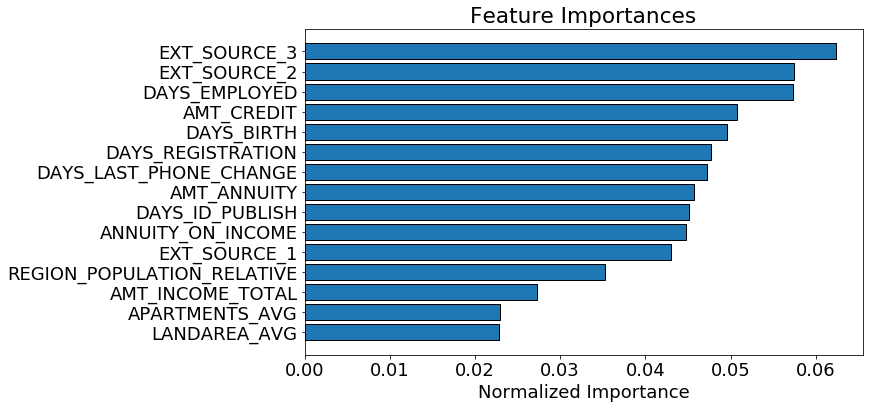

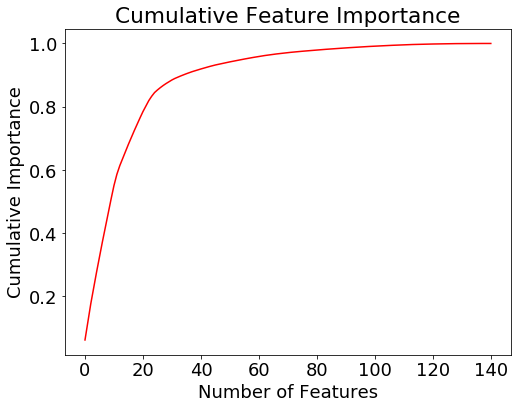

35 features required for 0.90 of cumulative importance


In [22]:
norm_feature_importances = gf.plot_feature_importances2(feature_importances)

In [29]:
norm_feature_importances.head(15)

,index,feature,importance,importance_normalized,cumulative_importance
0,24,EXT_SOURCE_3,25566,0.062356,0.062356
1,23,EXT_SOURCE_2,23537,0.057407,0.119763
2,6,DAYS_EMPLOYED,23485,0.057280,0.177044
3,2,AMT_CREDIT,20810,0.050756,0.227800
4,5,DAYS_BIRTH,20328,0.049580,0.277380
5,7,DAYS_REGISTRATION,19577,0.047749,0.325129
6,39,DAYS_LAST_PHONE_CHANGE,19379,0.047266,0.372395
7,3,AMT_ANNUITY,18724,0.045668,0.418063
8,8,DAYS_ID_PUBLISH,18484,0.045083,0.463146
9,56,ANNUITY_ON_INCOME,18346,0.044746,0.507893


35 features totalisent 90% d'importance cumulative.
Les 15 premières features qui totalisent 66% d'importance cumulative sont présentées dans le diagramme ci-dessus.